# Reuters newswire classification using DeepInsight

In [1]:
!pip install git+git://github.com/alok-ai-lab/DeepInsight.git#egg=DeepInsight

  Cloning git://github.com/alok-ai-lab/DeepInsight.git to /tmp/pip-install-h3lp42lx/DeepInsight
  Running command git clone -q git://github.com/alok-ai-lab/DeepInsight.git /tmp/pip-install-h3lp42lx/DeepInsight
  Created wheel for DeepInsight: filename=DeepInsight-0.1.0-cp37-none-any.whl size=17200 sha256=74d48777474712f1960f7198121fd0b0a4a1251248413a9fc0d412aed9afd61f
  Stored in directory: /tmp/pip-ephem-wheel-cache-lose1vyh/wheels/09/a1/8d/a4ad44a7b071322adf184d78a4433214364572696e2762d746
Successfully built DeepInsight


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [4]:
import tensorflow as tf
from keras.preprocessing import sequence
from tensorflow.keras import datasets, layers, models

In [5]:
from pyDeepInsight import ImageTransformer, LogScaler
from sklearn.model_selection import train_test_split

In [6]:
(x_train, y_train), (x_test, y_test) = datasets.reuters.load_data()

2113536/2110848 [==============================] - 0s 0us/step


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:148: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/reuters.py:149: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


In [7]:
len(x_train)

8982

In [8]:
MAXLEN = 250

In [10]:
x_train = sequence.pad_sequences(x_train, MAXLEN)
x_test = sequence.pad_sequences(x_test, MAXLEN)

In [11]:
ln = LogScaler()
X_train_norm = ln.fit_transform(x_train)
X_test_norm = ln.transform(x_test)

In [14]:
it = ImageTransformer(feature_extractor='tsne', 
                      pixels=100, random_state=1701, 
                      n_jobs=-1)

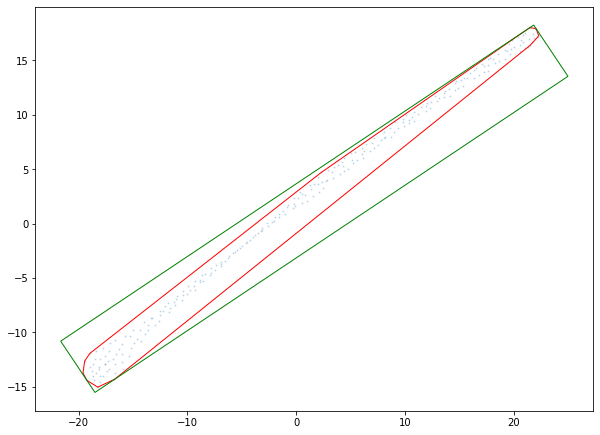

In [15]:
plt.figure(figsize=(10, 10))
it.fit(X_train_norm, plot=True)

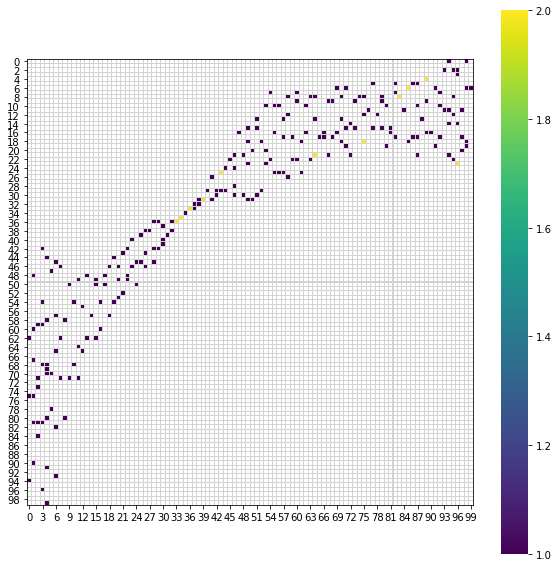

In [16]:
fdm = it.feature_density_matrix()
fdm[fdm == 0] = np.nan

plt.figure(figsize=(10, 10))

ax = sns.heatmap(fdm, cmap="viridis", linewidths=0.01, 
                 linecolor="lightgrey", square=True)
for _, spine in ax.spines.items():
    spine.set_visible(True)

In [17]:
mat_train = it.fit_transform(X_train_norm)
mat_test = it.transform(X_test_norm)

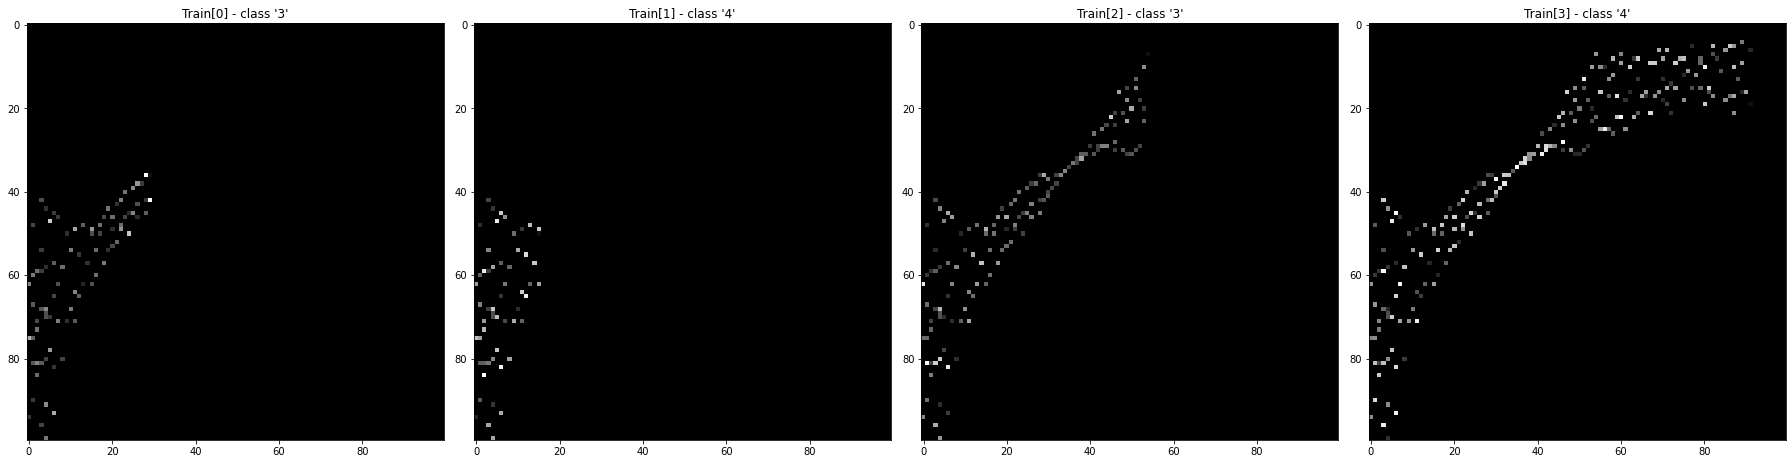

In [19]:
fig, ax = plt.subplots(1, 4, figsize=(25, 7))
for i in range(0,4):
    ax[i].imshow(mat_train[i])
    ax[i].title.set_text("Train[{}] - class '{}'".format(i, y_train[i]))
plt.tight_layout()

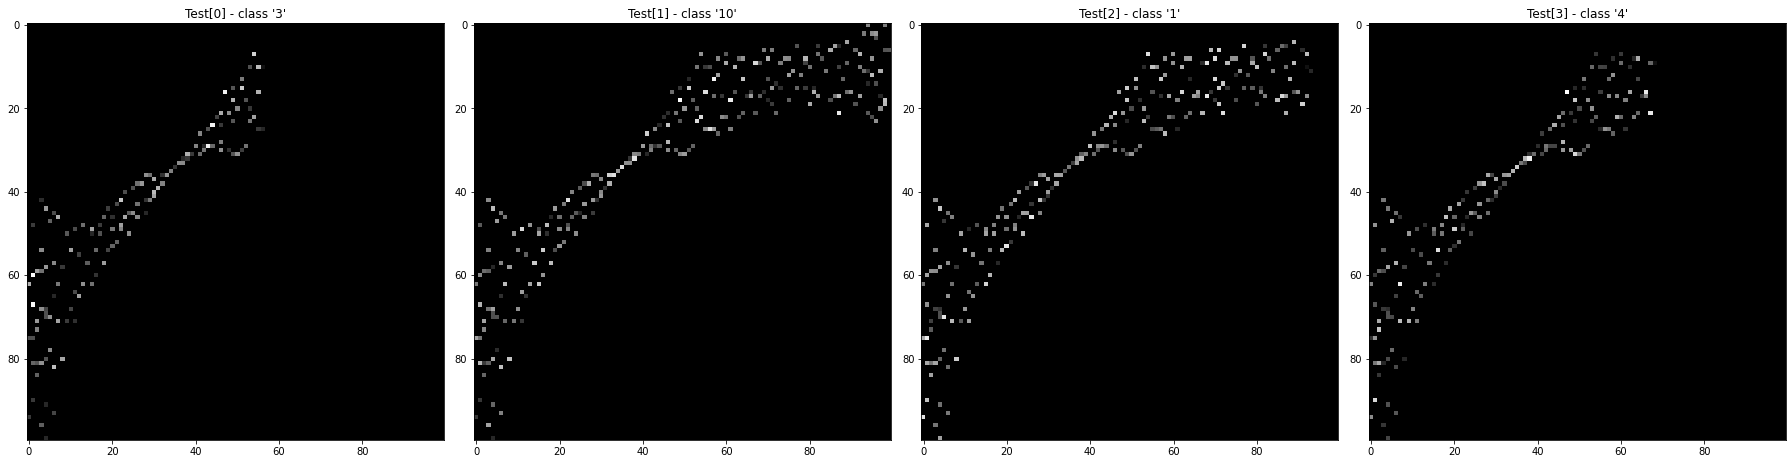

In [20]:
fig, ax = plt.subplots(1, 4, figsize=(25, 7))
for i in range(0,4):
    ax[i].imshow(mat_test[i])
    ax[i].title.set_text("Test[{}] - class '{}'".format(i, y_test[i]))
plt.tight_layout()

In [22]:
np.unique(y_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

In [23]:
np.unique(y_test)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

In [25]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=mat_train[0].shape))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(128, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(46))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 98, 98, 32)        896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 47, 47, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 21, 21, 128)       73856     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 64)         

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [27]:
model.fit(
    x=mat_train,
    y=y_train,
    batch_size=256,
    epochs=5,
)

Epoch 1/5
36/36 [==============================] - 148s 4s/step - loss: 3.1670 - accuracy: 0.2833
Epoch 2/5
36/36 [==============================] - 146s 4s/step - loss: 2.3589 - accuracy: 0.3755
Epoch 3/5
36/36 [==============================] - 146s 4s/step - loss: 2.3153 - accuracy: 0.3757
Epoch 4/5
36/36 [==============================] - 147s 4s/step - loss: 2.2760 - accuracy: 0.4014
Epoch 5/5
36/36 [==============================] - 148s 4s/step - loss: 2.2221 - accuracy: 0.4239


In [28]:
model.evaluate(mat_test, y_test)

71/71 [==============================] - 11s 149ms/step - loss: 2.2888 - accuracy: 0.3651


[2.288795232772827, 0.36509349942207336]